# Motivation for this notebook:
* Wanted a way to evaluate different approaches without having to submit to the public leaderboard.
* Wanted something faster than CV due to the time it took to run some of the experiments.

Instead of doing a typical CV approach, this notebook shows how bootstrapped samples can be used to evaluate the imputation method using out of bag samples. The idea is to take samples from our data set, with replacement, to train the imputation method (boostrapping). Since the selection of data is with replacement there will exist data not used to train the imputation method. The unused data points are the out-of-bag (OOB) samples and they will be used to evaluate the imputation method. 

Bootstrapping in picture form:

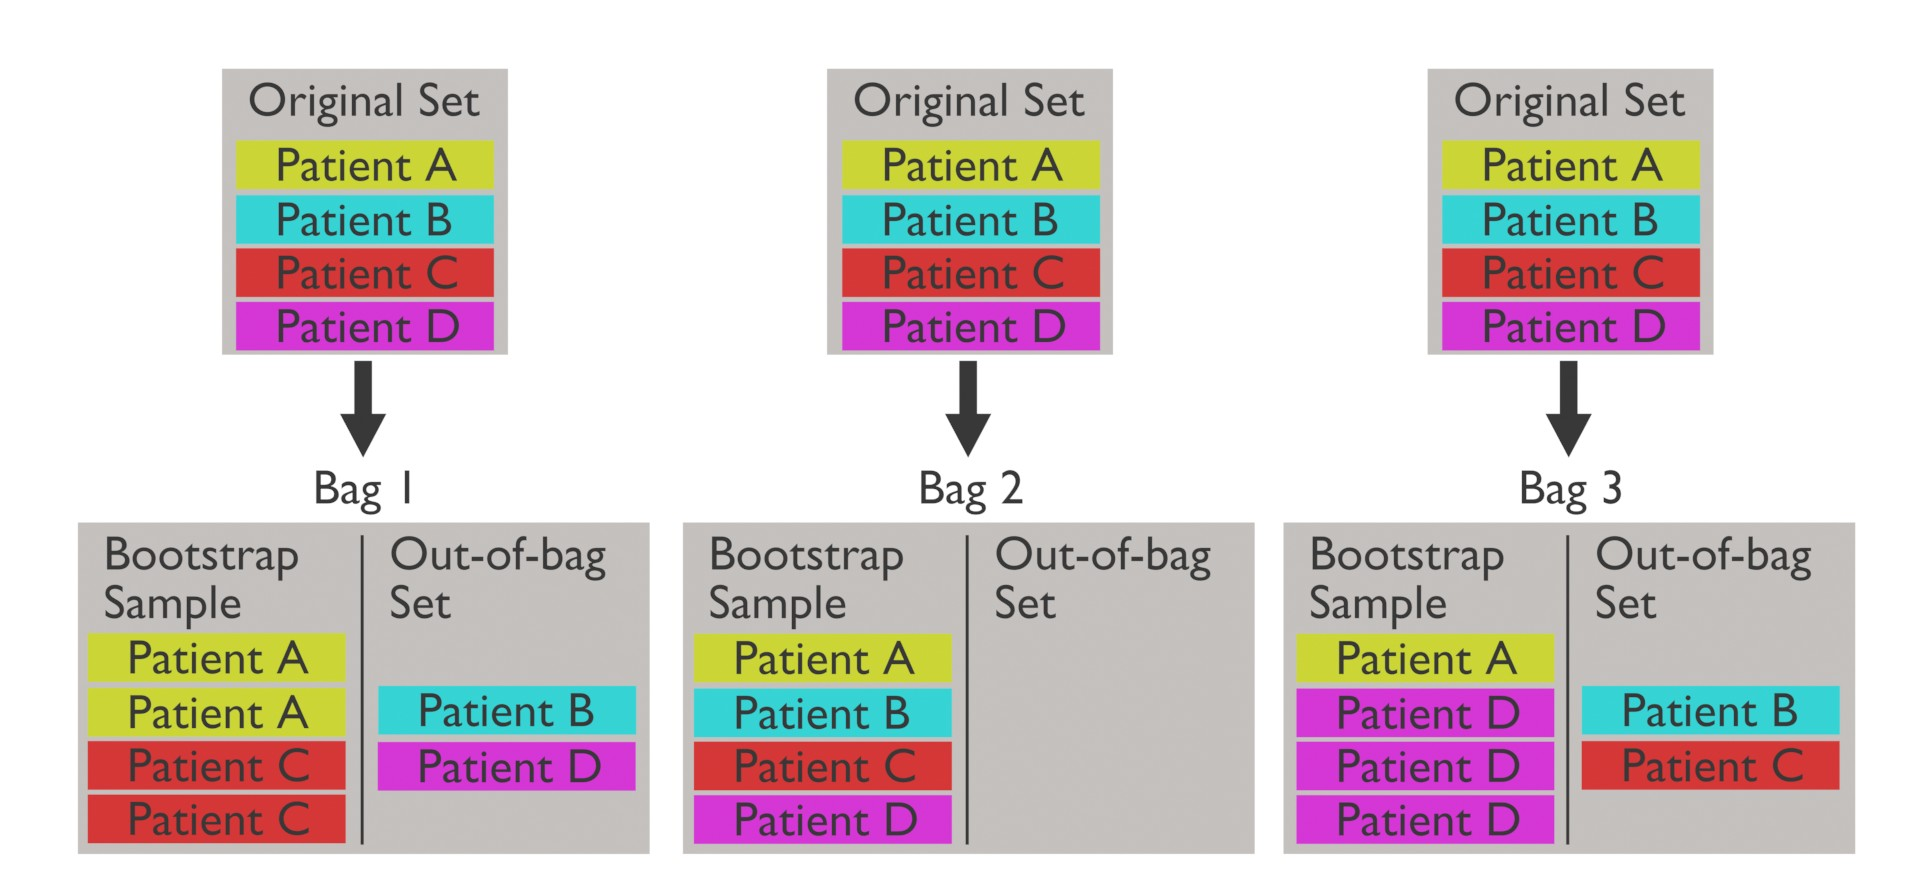
Source: [Out of Bag Error](https://en.wikipedia.org/wiki/Out-of-bag_error#:~:text=Out%2Dof%2Dbag%20(OOB,the%20model%20to%20learn%20from.)

# Imports and helper functions

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import statistics

from sklearn.impute import SimpleImputer 
from sklearn.linear_model import Ridge, Lasso, ARDRegression, ElasticNet, LassoLars, LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import optuna

In [ ]:
import datetime as dt

def print_time_stamp( Message ):
    """Returns a message with a time stamp at the end"""
    now = dt.datetime.now()
    now = now.strftime("%H:%M:%S")
    return(print(f"\n{Message} - {now}\n"))

In [ ]:
def missing_data(data):
    missing_count = data.isnull().sum()
    percent = (data.isnull().sum()/len(data)*100)
    tt = pd.concat([missing_count, percent], axis=1, keys=['Null Count', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [ ]:
def make_sub(sub_name, sub_data):
    
    submission = pd.read_csv('../input/tabular-playground-series-jun-2022/sample_submission.csv', index_col = 'row-col')
    
    for i in tqdm(submission.index):
        row = int(i.split('-')[0])
        col = i.split('-')[1]
        submission.loc[i, 'value'] = sub_data.loc[row, col]
    
    submission.to_csv(sub_name + '.csv')

# Data import

In [ ]:
data = pd.read_csv('../input/tabular-playground-series-jun-2022/data.csv', index_col = 'row_id')

In order to mimic our data, we need to understand how much information is missing from each feature.

In [ ]:
missing_data(data)

# How to evaluate our imputation approaches

Notes on the next function:
* p = 0.18 in the function below is due to how much missing data we have in each feature.
* By increasing the num_of_bags and setting make_comp_preds = True, you can create an ensemble of your imputation strategy.
* By decreasing the bag_size you can increase the speed at which this computes.
* The function mimics what the competition uses to evaluate a submission, ie, only the out-of-bag data is used to evaluate the imputation strategy.

In [ ]:
def compute_oob_estimate(num_of_bags = 1, imputation_strat = None, bag_size = 1000000, p = 0.18, make_comp_preds = False):
    
    results = [] 
    comp_results = []
    
    for i in range(num_of_bags):
        
        bag_index = np.random.choice(data.index, size = bag_size, replace=True)
        
        oob_index = list(set(data.index) - set(bag_index)) # list here so that it works with iloc
    
        bag = data.iloc[bag_index,:]
        oob = data.iloc[oob_index,:]
    
        oob_no_nan = oob.dropna() 
    
        mask = np.random.choice([True, False], size = oob_no_nan.shape, replace = True, p=[p,1-p]) 
    
        # replace the F_2 columns with all Falses as these columns shouldn't have any missing data 
        mask[:,15:40] = False
    
        # When mask is false, keep the original value. When mask is true, replace with nan.
        oob = oob_no_nan.mask(mask)
        
        print_time_stamp(Message = f'Fitting started on bag {i + 1}')
        
        imputation_strat.fit(bag)
    
        print_time_stamp(Message = f'Transform started on bag {i + 1}')
        
        oob_predicted = imputation_strat.transform(oob)
    
        # print_time_stamp(Message = f'Transform ended on bag {i + 1}') # the fit is where the time hit is
        
        # Use a mask so that you only compute the RMSE for those values that were imputed
        # we take the negation of the mask because we want the RMSE of just those values that were imputed above
        # when the mask is false, keep the original value. When the mask is true, replace with nan, ie, the data is masked ("invalid")
        true_values = np.ma.masked_array(oob_no_nan , mask = ~mask) 
        imputed_values = np.ma.masked_array(oob_predicted, mask = ~mask)
        
        # MSE
        masked_output = (imputed_values - true_values)**2
        
        # RMSE
        results.append(masked_output.mean()**0.5)
                                 
        ### compute what you would predict for the competition       
        if make_comp_preds:
            comp_results.append(pd.DataFrame(imputation_strat.transform(data), columns = data.columns))
    
    if make_comp_preds:
        return comp_results, results
    else:
        return results

# Testing the Function

The next code block shows how we can perform 5 iterations of bootstrapping with simple mean imputation. 

In [ ]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    
comp_imp_mean_results, imp_mean_results = compute_oob_estimate(num_of_bags = 5, imputation_strat = imp_mean, bag_size = 1000000, p = 0.18, make_comp_preds = True)

# Submission

In [ ]:
make_sub('mean_bootstrap5', sum(comp_imp_mean_results)/len(comp_imp_mean_results))

From the below you can see that the OOB error tracks very well with the public leaderboard as the mean_benchmark's public score is 1.41613.

In [ ]:
print(statistics.mean(imp_mean_results)) 
print(statistics.stdev(imp_mean_results)) 

# Next steps

* Tune your models
* See if the OOB error is correlated with your public leaderboard scores